# Project 1 - Results and Report by Mario Tokarz


## Code provided by Udacity

Udacity already provides a good set of helpers to get started, I have taken the ones I use over from your Notebook to this one.

### Udacity imports

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Helper functions 

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Mario's code

### Imports

In [3]:
import scipy.optimize as optimization
import datetime as time

### Helpers

In [4]:

"""
I use these global variables to apply exponential smoothening over two consequetive 
images in a video.

This method resets the values for previous and needs to be called before rendering an image
and before rendering a video (only once).

Working with globals is not a very beautiful solution, but I needed some way to store values
an cannot do it e.g. with methods as the API for the video processing is fix.
"""
def reset_prev():    
    global prev_r
    global prev_l

    prev_r = None
    prev_l = None

"""
This global parameter determines wheter pictures for debugging are stored.
"""
global debug 
debug = False

"""
Save images to folder "output" mainly for debugging purposes.
"""
def save_image_dbg(image, sequence, filename = "latest", force = False, gray = False):
    global debug
    if debug or force:
        if not gray:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
        stamp = '%s' % time.datetime.now()
        stamp = ""
        plt.savefig("output/" + filename + '_' + sequence + "_" + stamp +'.png', bbox_inches='tight')

    
"""
This is a function describing a line. I use it to fit a line through left and right lane 
markings. See description below
"""
def func(x, m, b):
    return m*x + b


"""
    This is my version of the draw_lines function where I used the one provided
    by Udacity as a starting point.
    
    I will describe the different sections / helper functions below.
"""
def draw_lines_enhanced(img, orig_img, lines, color=[255, 0, 0], thickness=6):
    
    # See below. These hold the parameters m and b for the line from the previous frame
    global prev_r
    global prev_l
    
    
    # Initialize arrays for the dots of the lines identified. This is needed for least squares below.
    xl = np.array([], dtype='f')
    yl = np.array([], dtype='f')
    
    xr = np.array([], dtype='f')
    yr = np.array([], dtype='f')
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
    
            # Calculate the slope of the current line
            m = (y2-y1)/(x2-x1)

            # Assumption: lane markings should run from bottom towards top of the picture,
            # This removes all lines which have a slope unlikely to belong to lane markings
            if m > -0.4 and m < 0.4:
                continue
                
            # We assume now that the lines left over are part of either the left or right lanemarking
            # The points can be assigned to the left or right by looking at the slope
            # The points are then added to the respective arrays
            if m < 0: # left lane
                xl = np.append(xl, x1);
                xl = np.append(xl, x2);
                yl = np.append(yl, y1);
                yl = np.append(yl, y2);
                
            if m > 0: # right lane
                xr = np.append(xr, x1);
                xr = np.append(xr, x2);
                yr = np.append(yr, y1);
                yr = np.append(yr, y2);

            
            
    # This section basically fits a line through our found points, left and right
    # In frames without sufficient info, we will use the previous line
    # Assuming a lane marking cannot change dramatically between two frames    
    if xl.size < 3 or xr.size < 3:
        save_image_dbg(img, "failed_to_fit", force = True)
        if prev_r is not None and prev_l is not None:
            resl = prev_l
            resr = prev_r
        else:
            return
    else:
        resl = optimization.curve_fit(func, xl, yl, [0.0, 0.0])
        resr = optimization.curve_fit(func, xr, yr, [0.0, 0.0])

    # Apply exponential smoothin in case we do have previous information
    if prev_r is not None and prev_l is not None:
        fact = 0.1
        resl[0][0] = fact*resl[0][0] + (1-fact)*prev_l[0][0] 
        resl[0][1] = fact*resl[0][1] + (1-fact)*prev_l[0][1]
        resr[0][0] = fact*resr[0][0] + (1-fact)*prev_r[0][0]
        resr[0][1] = fact*resr[0][1] + (1-fact)*prev_r[0][1]
    
    # Store global variables for the next frame.
    prev_l = resl
    prev_r = resr
    
    # Now the drawing can begin. 
    # We need to dots per line, as x value, we use similar parameters to our region of interest
    # The y values can be calculated using the function and the parameters gained through least squares fitting
    imshape = img.shape
    l = np.array([imshape[1]*120/960, 
                  int(func(imshape[1]*120/960, resl[0][0], resl[0][1])),
                  imshape[1]*440/960,
                  int(func(imshape[1]*440/960, resl[0][0], resl[0][1]))], dtype='i')
    r = np.array([imshape[1]*520/960, 
                  int(func(imshape[1]*520/960, resr[0][0], resr[0][1])), 
                  imshape[1]*890/960, 
                  int(func(imshape[1]*890/960, resr[0][0], resr[0][1]))], dtype ='i')

    cv2.line(img, 
             (l[0], l[1]),
             (l[2], l[3]),
             color, 
             thickness)
    
    cv2.line(img, 
             (r[0], r[1]),
             (r[2], r[3]),        
             color, 
             thickness)
    

def hough_lines_enhanced(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_enhanced(line_img, img, lines)
    return line_img

### The Pipeline

In [5]:
# Manual pipeline built on top of one image
def apply_pipeline(image):
    gray = grayscale(image)
    save_image_dbg(gray, "grayscale", gray = True)
    
    gray = gaussian_blur(gray, 5)
    save_image_dbg(gray, "blur", gray = True)

    gray = canny(gray, 50, 150)
    save_image_dbg(gray, "canny", gray = True)

    imshape = gray.shape
    
    # Set the region of interest based on the vertices above
    
    """
    Some thoughts on this one:
    
    1. The videos have different resolutions while the camera and with it
    the ratios seem to be the same. I have therefore chosen to use factors in 
    combination with the image dimension. I determined the factors by rendering 
    the image with a grid. 
    
    2. Specifically in one video, parts of the car are visible. A simple solution
    is to cut off a small part of the image. This should not affect overall detection too much.
    In this case, the cut off is chosen as 0.05 percent.
    """
    vertices = np.array([[
        (imshape[1]*120/960, 0.95*imshape[0]),
        (imshape[1]*480/960, imshape[0]*310/540), 
        (imshape[1]*520/960, imshape[0]*310/540), 
        (imshape[1]*890/960, 0.95*imshape[0])]], dtype=np.int32)
    
    gray = region_of_interest(gray, vertices)
    
    save_image_dbg(cv2.fillPoly(np.copy (image), vertices, 1), "region_of_interest_marked")
    save_image_dbg(gray, "region_of_interest", gray = True)
    
    # Call hough_lines with the enhanced version of the drawing method provided in the section above
    gray = hough_lines_enhanced(gray, rho = 2, theta = np.pi/180, threshold = 50, min_line_len = 50, max_line_gap = 20)
    save_image_dbg(gray, "houghlines")
    
    # Combine original and line image
    gray = weighted_img(gray, image)

    return gray

## Putting it together

### Static pictures

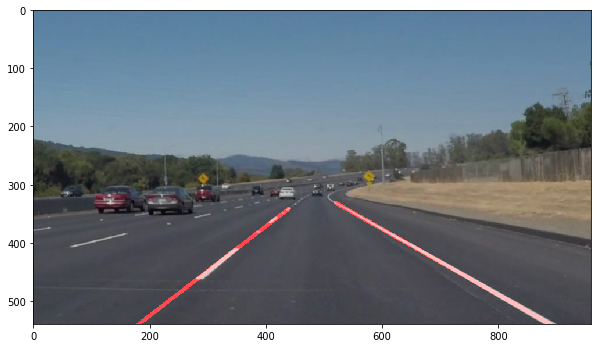

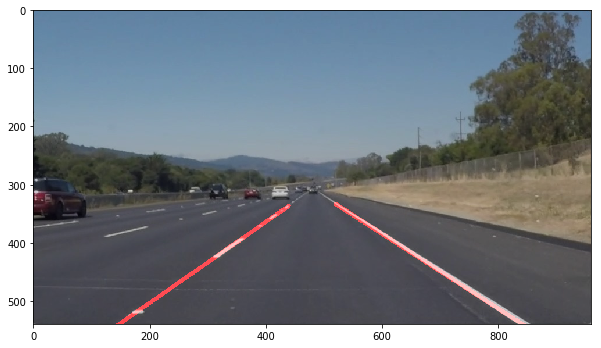

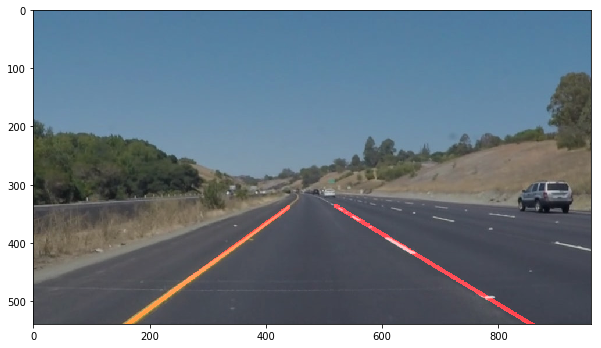

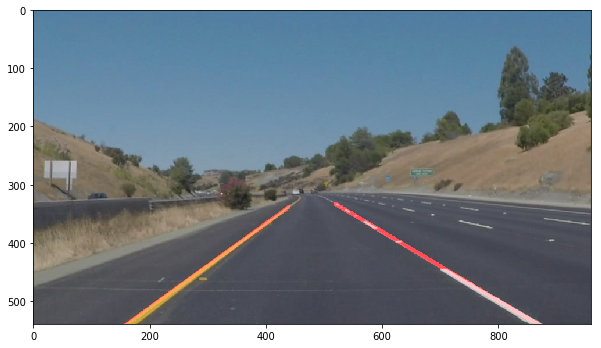

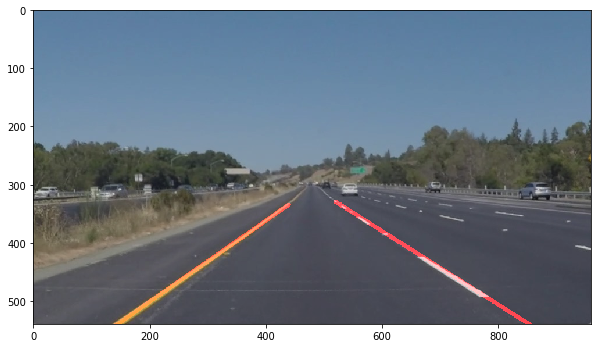

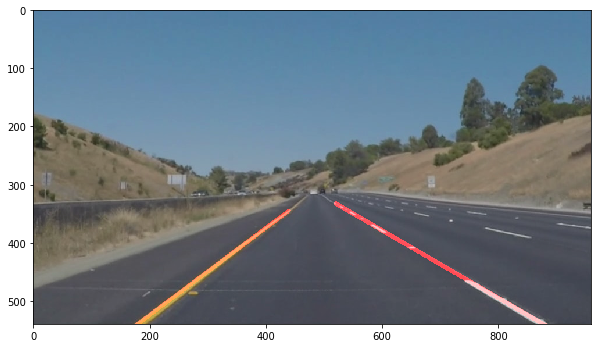

In [6]:
import os
base = "test_images/"
files = os.listdir(base)


for index in range(len(files)):
    image = mpimg.imread(base + files[index])
    
    reset_prev()
    result = apply_pipeline(image)
    fig = plt.figure(figsize=(10, 40))

    plt.imshow(result)
    plt.savefig("output/" + "result_" + files[index], bbox_inches='tight')


### Videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global debug
debug = False

In [8]:
def process_image(image):
    result = apply_pipeline(image)
    return result

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 30.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 15.6 s, sys: 3.21 s, total: 18.8 s
Wall time: 15.6 s


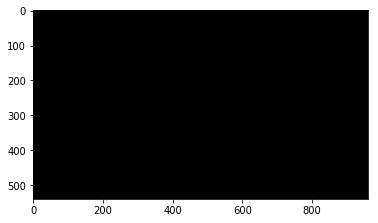

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_prev()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.49 s, sys: 2.7 s, total: 12.2 s
Wall time: 17.5 s


[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:45<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 44s, sys: 14 s, total: 1min 58s
Wall time: 1min 46s


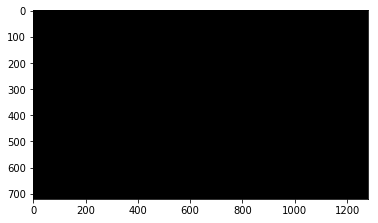

In [11]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))